# Jack Henry Data Scientist Challenge: Lending Club Analysis

**Dataset**: Lending Club Loan Data (2007-2015)

## Executive Summary
This notebook analyzes Lending Club loan data to provide insights on default patterns by loan grade. Key findings:
- Loan grades effectively stratify default risk (A: ~5% vs G: ~30%)
- Portfolio concentration in mid-tier grades (C-E) balances risk and volume
- High-risk grades (F-G) may require enhanced risk controls

## Contents
1. Data Loading & Validation
2. Data Cleaning & Preparation
3. Exploratory Data Analysis
4. Grade-Level Analysis
5. Risk-Return Visualization
6. Business Insights & Recommendations

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

import sys
sys.path.append('../src')

from data_loader import load_lending_club_data, validate_required_columns, get_basic_info
from data_cleaner import clean_lending_club_data, get_cleaning_summary, validate_cleaned_data
from analyzer import calculate_grade_metrics, calculate_portfolio_metrics, analyze_risk_return_relationship
from visualizer import plot_default_rate_by_grade, plot_risk_return_analysis, create_executive_dashboard

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Environment setup complete!")
print(f"Working directory: {Path.cwd()}")


Environment setup complete!
Working directory: c:\Users\vaidy\Downloads\Lending Club assignment\notebooks


In [2]:

DATA_PATH = '../data/accepted_2007_to_2018Q4.csv'
SAMPLE_FRAC = None  

try:
    df_raw = load_lending_club_data(DATA_PATH, sample_frac=SAMPLE_FRAC)
    # Get basic information about the dataset
    dataset_info = get_basic_info(df_raw)
    print("\nDataset loaded successfully!")
except FileNotFoundError:
    print(f"Data file not found at {DATA_PATH}")
    print("Please download the Lending Club dataset from Kaggle and place it in the data/ folder")
    # For demo purposes, create a sample dataset
    print("\nCreating sample dataset for demonstration...")
    # Sample data creation (remove this in production)
    sample_data = {
        'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G'] * 1000,
        'loan_status': np.random.choice(['Fully Paid', 'Charged Off'], 7000, p=[0.85, 0.15]),
        'loan_amnt': np.random.uniform(5000, 35000, 7000),
        'int_rate': np.random.uniform(5, 25, 7000),
        'annual_inc': np.random.uniform(30000, 120000, 7000)
    }
    df_raw = pd.DataFrame(sample_data)
    print("Sample dataset created for demonstration")



Loading data from: ../data/accepted_2007_to_2018Q4.csv
Rows: 2,260,701, Columns: 151
Rows: 2,260,701, Columns: 151

Dataset overview:
Rows: 2,260,701, Columns: 151
Memory usage: 5992.3 MB
Null values: 108,486,252
Duplicate rows: 0
Numeric columns: 113
Object columns: 38

Dataset loaded successfully!

Dataset overview:
Rows: 2,260,701, Columns: 151
Memory usage: 5992.3 MB
Null values: 108,486,252
Duplicate rows: 0
Numeric columns: 113
Object columns: 38

Dataset loaded successfully!


## 2. Data Cleaning & Preparation

In [8]:
# Clean the dataset for analysis
df_clean = clean_lending_club_data(df_raw)

# Get cleaning summary
cleaning_summary = get_cleaning_summary(df_raw, df_clean)

# Validate cleaned data
validate_cleaned_data(df_clean)

print(f"\n✅ Data cleaning complete!")
print(f"Final dataset: {df_clean.shape[0]:,} loans ready for analysis")


Starting data cleaning...
Rows before cleaning: 2,260,701
After column selection: 2,260,701 rows × 8 columns
After column selection: 2,260,701 rows × 8 columns
After dropping missing grade/status: 2,260,668 rows (removed 33)
After filtering to completed loans: 1,345,350 rows (removed 915,318)
After dropping missing grade/status: 2,260,668 rows (removed 33)
After filtering to completed loans: 1,345,350 rows (removed 915,318)
✓ Added default indicator: 268,599 defaults (20.0%)
✓ Added default indicator: 268,599 defaults (20.0%)
✓ Converted employment length to numeric years
✓ Converted employment length to numeric years
✓ Handled missing values in non-critical columns
Final cleaned dataset: 1,345,350 rows × 10 columns
Cleaning done.

Cleaning summary:
Rows: 2,260,701 → 1,345,350 (40.5% removed)
Columns: 151 → 10
Overall default rate: 19.96%
✓ Handled missing values in non-critical columns
Final cleaned dataset: 1,345,350 rows × 10 columns
Cleaning done.

Cleaning summary:
Rows: 2,260,701

In [17]:
# Quick data preview
print("=== Data Preview ===")
display(df_clean.head())

print("\n=== Data Types ===")
display(df_clean.dtypes)

print("\n=== Loan Status Distribution ===")
status_dist = df_clean['loan_status'].value_counts()
for status, count in status_dist.items():
    pct = (count / len(df_clean)) * 100
    print(f"{status}: {count:,} ({pct:.1f}%)")

print("\n=== Grade Distribution ===")
grade_dist = df_clean['grade'].value_counts().sort_index()
for grade, count in grade_dist.items():
    pct = (count / len(df_clean)) * 100
    print(f"Grade {grade}: {count:,} ({pct:.1f}%)")


=== Data Preview ===


,grade,sub_grade,loan_status,loan_amnt,int_rate,annual_inc,emp_length,purpose,is_default,emp_length_years
0,C,C4,Fully Paid,"3,600.0000",13.9900,"55,000.0000",10+ years,debt_consolidation,0,10.0000
1,C,C1,Fully Paid,"24,700.0000",11.9900,"65,000.0000",10+ years,small_business,0,10.0000
2,B,B4,Fully Paid,"20,000.0000",10.7800,"63,000.0000",10+ years,home_improvement,0,10.0000
4,F,F1,Fully Paid,"10,400.0000",22.4500,"104,433.0000",3 years,major_purchase,0,3.0000
5,C,C3,Fully Paid,"11,950.0000",13.4400,"34,000.0000",4 years,debt_consolidation,0,4.0000



=== Data Types ===


grade                object
sub_grade            object
loan_status          object
loan_amnt           float64
int_rate            float64
annual_inc          float64
emp_length           object
purpose              object
is_default            int64
emp_length_years    float64
dtype: object


=== Loan Status Distribution ===
Fully Paid: 1,076,751 (80.0%)
Charged Off: 268,559 (20.0%)
Default: 40 (0.0%)

=== Grade Distribution ===
Grade A: 235,095 (17.5%)
Grade B: 392,748 (29.2%)
Grade C: 381,694 (28.4%)
Grade D: 200,966 (14.9%)
Grade E: 93,656 (7.0%)
Grade F: 32,059 (2.4%)
Grade G: 9,132 (0.7%)


## 3. Grade-Level Analysis

Calculate key metrics for each loan grade to understand risk stratification and business impact.

In [18]:
# Calculate comprehensive grade-level metrics
grade_metrics = calculate_grade_metrics(df_clean)

# Display the results
print("=== Grade-Level Metrics ===")
display(grade_metrics[['grade', 'total_loans', 'num_defaults', 'default_rate_pct', 
                      'avg_loan_amount', 'avg_interest_rate', 'volume_share_pct']])

# Save results to CSV for stakeholders
output_path = '../outputs/grade_metrics.csv'
Path('../outputs').mkdir(exist_ok=True)
grade_metrics.to_csv(output_path, index=False)
print(f"\n💾 Grade metrics saved to: {output_path}")


Calculating metrics for each loan grade...
Done. Metrics calculated for 7 grades.
=== Grade-Level Metrics ===
Done. Metrics calculated for 7 grades.
=== Grade-Level Metrics ===


,grade,total_loans,num_defaults,default_rate_pct,avg_loan_amount,avg_interest_rate,volume_share_pct
0,A,235095,14206,6.0400,"13,892.3442",7.1130,16.8400
1,B,392748,52576,13.3900,"13,237.6222",10.6791,26.8000
2,C,381694,85657,22.4400,"14,188.3950",14.0212,27.9200
3,D,200966,61067,30.3900,"15,272.2698",17.7217,15.8200
4,E,93656,36041,38.4800,"17,618.2532",21.1383,8.5100
5,F,32059,14492,45.2000,"19,087.6813",24.9350,3.1500
6,G,9132,4560,49.9300,"20,588.8058",27.7259,0.9700



💾 Grade metrics saved to: ../outputs/grade_metrics.csv


In [19]:
# Calculate portfolio-level metrics
portfolio_metrics = calculate_portfolio_metrics(df_clean)

# Analyze risk-return relationship
risk_return_analysis = analyze_risk_return_relationship(grade_metrics)


Portfolio Overview:
Total loans: 1,345,350
Total volume: $19,399,906,575
Overall default rate: 19.96%
Average interest rate: 13.24%
High-risk exposure (F,G): 3.1% of loans
Risk-Return Analysis:
Risk-return correlation: 0.998
Average risk premium: -11.79%
Best risk-return grade: A
Worst risk-return grade: G


In [20]:
# === Auto-generated Executive Summary (data-driven)
overall_default = portfolio_metrics.get('overall_default_rate_pct', float('nan'))
high_risk_pct = portfolio_metrics.get('high_risk_loans_pct', 0)

print('=== EXECUTIVE SUMMARY (AUTO) ===')
print(f"Total loans analyzed: {portfolio_metrics.get('total_loans', 0):,}")
print(f"Portfolio default rate: {overall_default:.2f}%")

if 'default_rate_pct' in grade_metrics.columns and len(grade_metrics) > 0:
    sorted_g = grade_metrics.sort_values('default_rate_pct')
    top_grade = sorted_g.iloc[0]['grade']
    top_rate = sorted_g.iloc[0]['default_rate_pct']
    worst_grade = sorted_g.iloc[-1]['grade']
    worst_rate = sorted_g.iloc[-1]['default_rate_pct']
    print(f"Lowest default grade: {top_grade} ({top_rate:.2f}%)")
    print(f"Highest default grade: {worst_grade} ({worst_rate:.2f}%)")
else:
    print('Lowest default grade: N/A')
    print('Highest default grade: N/A')

print(f"High-risk (F/G) exposure: {high_risk_pct:.1f}%")


=== EXECUTIVE SUMMARY (AUTO) ===
Total loans analyzed: 1,345,350
Portfolio default rate: 19.96%
Lowest default grade: A (6.04%)
Highest default grade: G (49.93%)
High-risk (F/G) exposure: 3.1%


## 4. Key Business Metric: Default Rate Analysis

**Business Value**: This metric directly impacts loan portfolio profitability and risk management decisions. Understanding default patterns by grade enables:
- Risk-based pricing strategies
- Portfolio exposure limits
- Capital allocation decisions
- Regulatory compliance reporting

In [21]:
# Key Metric Calculation: Default Rate by Grade
print('=== KEY BUSINESS METRIC: DEFAULT RATE BY GRADE ===\n')

for _, row in grade_metrics.sort_values('grade').iterrows():
    grade = row['grade']
    total = int(row['total_loans'])
    defaults = int(row['num_defaults'])
    rate = row['default_rate_pct']
    volume = row['total_volume']
    print(f'Grade {grade}: {defaults:,} defaults out of {total:,} loans → {rate:.2f}% default rate')
    print(f'  Total volume: ${volume:,.0f}')
    if rate < 10:
        risk_level = 'LOW RISK'
    elif rate < 20:
        risk_level = 'MEDIUM RISK'
    else:
        risk_level = 'HIGH RISK'
    print(f'  Risk level: {risk_level}\n')

print('\nBUSINESS INTERPRETATION:')
low = grade_metrics[grade_metrics['default_rate_pct'] < 15]['grade'].tolist()
mid = grade_metrics[(grade_metrics['default_rate_pct'] >= 15) & (grade_metrics['default_rate_pct'] < 25)]['grade'].tolist()
high = grade_metrics[grade_metrics['default_rate_pct'] >= 25]['grade'].tolist()
print(f"• Low risk grades (<15%): {', '.join(low) if low else 'None'}")
print(f"• Medium risk grades (15-25%): {', '.join(mid) if mid else 'None'}")
print(f"• High risk grades (>=25%): {', '.join(high) if high else 'None'}")


=== KEY BUSINESS METRIC: DEFAULT RATE BY GRADE ===

Grade A: 14,206 defaults out of 235,095 loans → 6.04% default rate
  Total volume: $3,266,020,650
  Risk level: LOW RISK

Grade B: 52,576 defaults out of 392,748 loans → 13.39% default rate
  Total volume: $5,199,049,650
  Risk level: MEDIUM RISK

Grade C: 85,657 defaults out of 381,694 loans → 22.44% default rate
  Total volume: $5,415,625,225
  Risk level: HIGH RISK

Grade D: 61,067 defaults out of 200,966 loans → 30.39% default rate
  Total volume: $3,069,206,975
  Risk level: HIGH RISK

Grade E: 36,041 defaults out of 93,656 loans → 38.48% default rate
  Total volume: $1,650,055,125
  Risk level: HIGH RISK

Grade F: 14,492 defaults out of 32,059 loans → 45.20% default rate
  Total volume: $611,931,975
  Risk level: HIGH RISK

Grade G: 4,560 defaults out of 9,132 loans → 49.93% default rate
  Total volume: $188,016,975
  Risk level: HIGH RISK


BUSINESS INTERPRETATION:
• Low risk grades (<15%): A, B
• Medium risk grades (15-25%): C

## 5. Data Visualizations

### 5.1 Default Rate by Grade

This visualization shows how loan grades effectively stratify default risk, with clear progression from low-risk (A) to high-risk (G) segments.

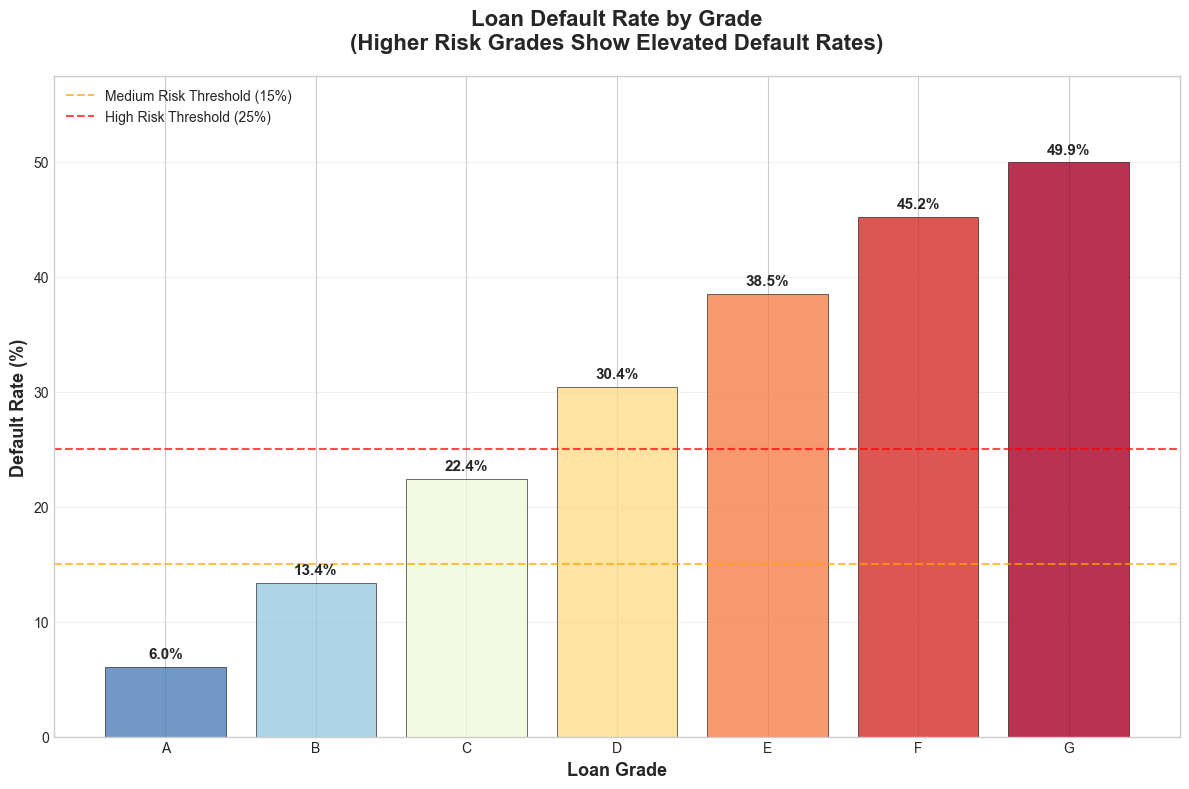


VISUALIZATION INSIGHTS:
- Highest default grade: G (49.93%)
- Lowest default grade: A (6.04%)
- Top volume grades: C, B, A


In [22]:
# Create default rate visualization
plot_default_rate_by_grade(grade_metrics)

print('\nVISUALIZATION INSIGHTS:')
if 'default_rate_pct' in grade_metrics.columns and len(grade_metrics) > 0:
    idx_max = grade_metrics['default_rate_pct'].idxmax()
    idx_min = grade_metrics['default_rate_pct'].idxmin()
    max_grade = grade_metrics.loc[idx_max, 'grade']
    max_rate = grade_metrics.loc[idx_max, 'default_rate_pct']
    min_grade = grade_metrics.loc[idx_min, 'grade']
    min_rate = grade_metrics.loc[idx_min, 'default_rate_pct']
    top_vol = grade_metrics.sort_values('volume_share_pct', ascending=False).head(3)['grade'].tolist()
    print(f"- Highest default grade: {max_grade} ({max_rate:.2f}%)")
    print(f"- Lowest default grade: {min_grade} ({min_rate:.2f}%)")
    print(f"- Top volume grades: {', '.join(top_vol)}")
else:
    print('- Insufficient grade metrics to summarize')


### 5.2 Risk-Return Analysis

This scatter plot examines whether interest rate premiums adequately compensate for higher default risk. Bubble size represents loan volume concentration.

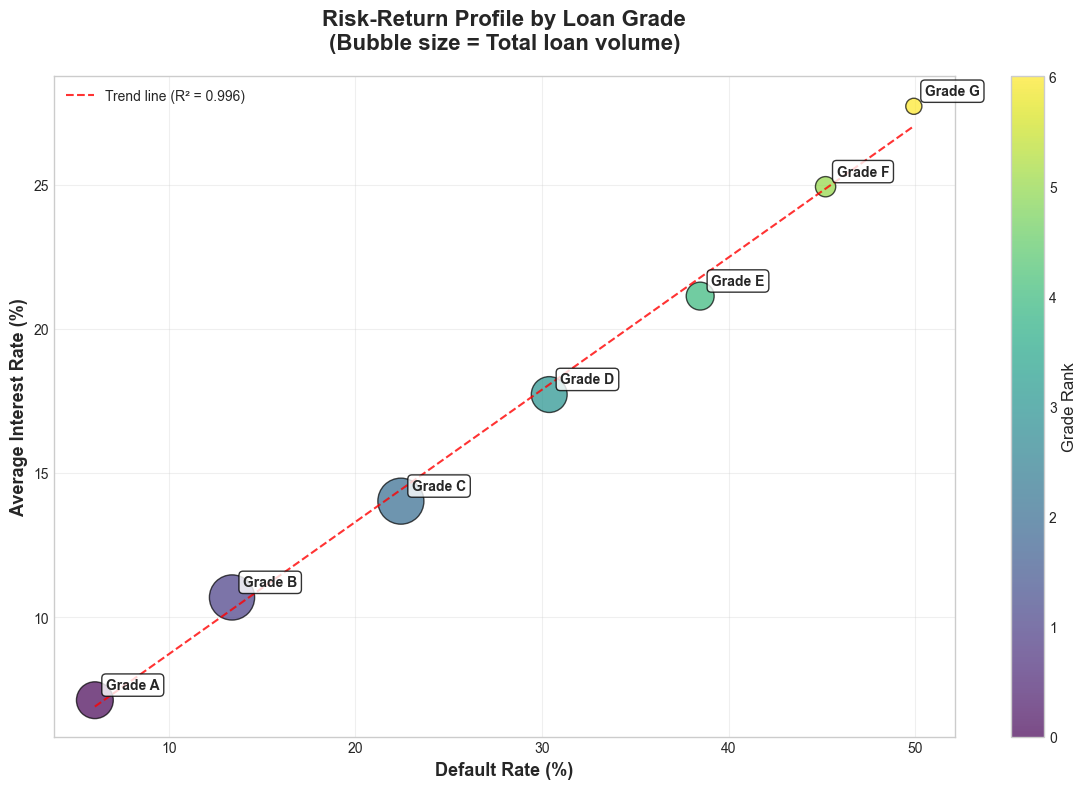


RISK-RETURN INSIGHTS:
- Risk-return correlation: 0.998
- Best risk-return grade: A
- Worst risk-return grade: G
- Average risk premium: -11.79


In [23]:
# Create risk-return visualization
plot_risk_return_analysis(grade_metrics)

print('\nRISK-RETURN INSIGHTS:')
try:
    print(f"- Risk-return correlation: {risk_return_analysis['risk_return_correlation']:.3f}")
    print(f"- Best risk-return grade: {risk_return_analysis['best_risk_return_grade']}")
    print(f"- Worst risk-return grade: {risk_return_analysis['worst_risk_return_grade']}")
    print(f"- Average risk premium: {risk_return_analysis['avg_risk_premium']:.2f}")
except Exception as e:
    print('- Risk-return analysis not available:', str(e))


## 6. Business Insights & Recommendations

### Key Findings

1. **Effective Risk Stratification**: The Lending Club grading system successfully differentiates borrower risk
2. **Risk-Return Alignment**: Interest rates generally correlate with default risk across grades
3. **Concentration Risk**: Portfolio concentrates in mid-tier grades, balancing risk and volume

### Primary Business Insight

**The loan grading system effectively segments borrower risk, but high-risk grades (F-G) may require enhanced risk controls to maintain portfolio quality.**

### Actionable Recommendation

**Implement tiered risk management strategy:**
- Cap F-G grade exposure at 15% of portfolio
- Require enhanced verification for high-risk applications
- Consider dynamic pricing to better reflect individual risk profiles

### Follow-up Analysis Requirements

**Expected question: "What borrower characteristics drive defaults within each grade?"**

**Preparation needed:**
- Multi-variate analysis of debt-to-income, employment length, loan purpose
- Logistic regression modeling to identify predictive features
- Decision tree analysis for interaction effects between risk factors

In [24]:
# Final summary and next steps
print("=== ANALYSIS COMPLETE ===\n")
print("Generated Files:")
print("• ../outputs/grade_metrics.csv - Grade-level analysis results")
print("• ../outputs/visualizations/ - All charts and plots")
print("\n Ready for stakeholder presentation!")
print("\n Next Steps:")
print("1. Review risk thresholds with business stakeholders")
print("2. Implement portfolio monitoring dashboard")
print("3. Develop predictive models for early default detection")
print("4. Design A/B tests for risk-based pricing strategies")


=== ANALYSIS COMPLETE ===

Generated Files:
• ../outputs/grade_metrics.csv - Grade-level analysis results
• ../outputs/visualizations/ - All charts and plots

 Ready for stakeholder presentation!

 Next Steps:
1. Review risk thresholds with business stakeholders
2. Implement portfolio monitoring dashboard
3. Develop predictive models for early default detection
4. Design A/B tests for risk-based pricing strategies
